In [43]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from alibi.explainers import PartialDependence, plot_pd, PartialDependenceVariance, plot_pd_variance, ALE, plot_ale, PermutationImportance, plot_permutation_importance
from xgboost import XGBClassifier
from pathlib import Path

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv')
df = df.drop(['dteday', 'registered', 'casual'], axis=1)
df.head()

,instant,season,yr,mnth,holiday,weekday,temp,atemp,hum,windspeed,cnt,workday,weather,days_since_2011,cnt_2d_bfr
0,3,WINTER,2011,JAN,N,MON,1.229108,22.439770,43.7273,16.636703,1349,Y,GOOD,2,985
1,4,WINTER,2011,JAN,N,TUE,1.400000,23.212148,59.0435,10.739832,1562,Y,GOOD,3,801
2,5,WINTER,2011,JAN,N,WED,2.666979,23.795180,43.6957,12.522300,1600,Y,GOOD,4,1349
3,6,WINTER,2011,JAN,N,THU,1.604356,23.929106,51.8261,6.000868,1606,Y,GOOD,5,1562
4,7,WINTER,2011,JAN,N,FRI,1.236534,23.100526,49.8696,11.304642,1510,Y,MISTY,6,1600


In [3]:
feature_names = df.columns.tolist()
feature_names.remove('cnt')

target_names = ['Number of Bikes']
categorical_columns_names = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workday', 'weather']

categorical_columns_indices = [feature_names.index(cn) for cn in categorical_columns_names]
numerical_columns_indices = [feature_names.index(cn) for cn in feature_names if cn not in categorical_columns_names]

X = df[feature_names]
y = df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(categorical_columns_indices, numerical_columns_indices)

[1, 2, 3, 4, 5, 10, 11] [0, 6, 7, 8, 9, 12, 13]


In [4]:
oe = OrdinalEncoder().fit(X_train[categorical_columns_names])
X_train.loc[:, categorical_columns_names] = oe.transform(X_train[categorical_columns_names])
X_test.loc[:, categorical_columns_names] = oe.transform(X_test[categorical_columns_names])

X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

categorical_names = {i:list(v) for i, v in zip(categorical_columns_indices, oe.categories_)}
categorical_names

{1: ['FALL', 'SPRING', 'SUMMER', 'WINTER'],
 2: [2011, 2012],
 3: ['APR',
  'AUG',
  'DEC',
  'FEB',
  'JAN',
  'JUL',
  'JUN',
  'MAR',
  'MAY',
  'NOV',
  'OCT',
  'SEP'],
 4: ['N', 'Y'],
 5: ['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'],
 10: ['N', 'Y'],
 11: ['BAD', 'GOOD', 'MISTY']}

In [5]:
preprocessor = ColumnTransformer([('num', StandardScaler(), numerical_columns_indices),
                                  ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_columns_indices)])
preprocessor.fit(X_train)
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

In [6]:
predictor = RandomForestRegressor(random_state=0)
predictor.fit(X_train_ohe, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [7]:
predictor.score(X_train_ohe, y_train), predictor.score(X_test_ohe, y_test)

(0.9817083893337574, 0.8843882268668817)

In [8]:
prediction_fn = lambda x: predictor.predict(preprocessor.transform(x))

In [9]:
explainer = PartialDependence(predictor=prediction_fn, feature_names=feature_names, target_names=target_names, categorical_names=categorical_names)

In [10]:
features = [feature_names.index('temp'), feature_names.index('hum'), feature_names.index('windspeed'), feature_names.index('season')]
features

[6, 8, 9, 1]

In [11]:
exp = explainer.explain(X=X_train, features=features, kind='average')
exp

Explanation(meta={
  'name': 'PartialDependence',
  'type': ['blackbox'],
  'explanations': ['global'],
  'params': {
              'kind': 'average',
              'percentiles': (0.0, 1.0),
              'grid_resolution': 100,
              'feature_names': ['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'workday', 'weather', 'days_since_2011', 'cnt_2d_bfr'],
              'categorical_names': {
                                     1: ['FALL', 'SPRING', 'SUMMER', 'WINTER'],
                                     2: [2011, 2012],
                                     3: ['APR', 'AUG', 'DEC', 'FEB', 'JAN', 'JUL', 'JUN', 'MAR', 'MAY', 'NOV', 'OCT', 'SEP'],
                                     4: ['N', 'Y'],
                                     5: ['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'],
                                     10: ['N', 'Y'],
                                     11: ['BAD', 'GOOD', 'MISTY']}
                            

array([[<AxesSubplot:xlabel='temp', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='hum', ylabel='Number of Bikes'>,
        <AxesSubplot:xlabel='windspeed', ylabel='Number of Bikes'>],
       [<AxesSubplot:xlabel='season', ylabel='Number of Bikes'>, None,
        None]], dtype=object)

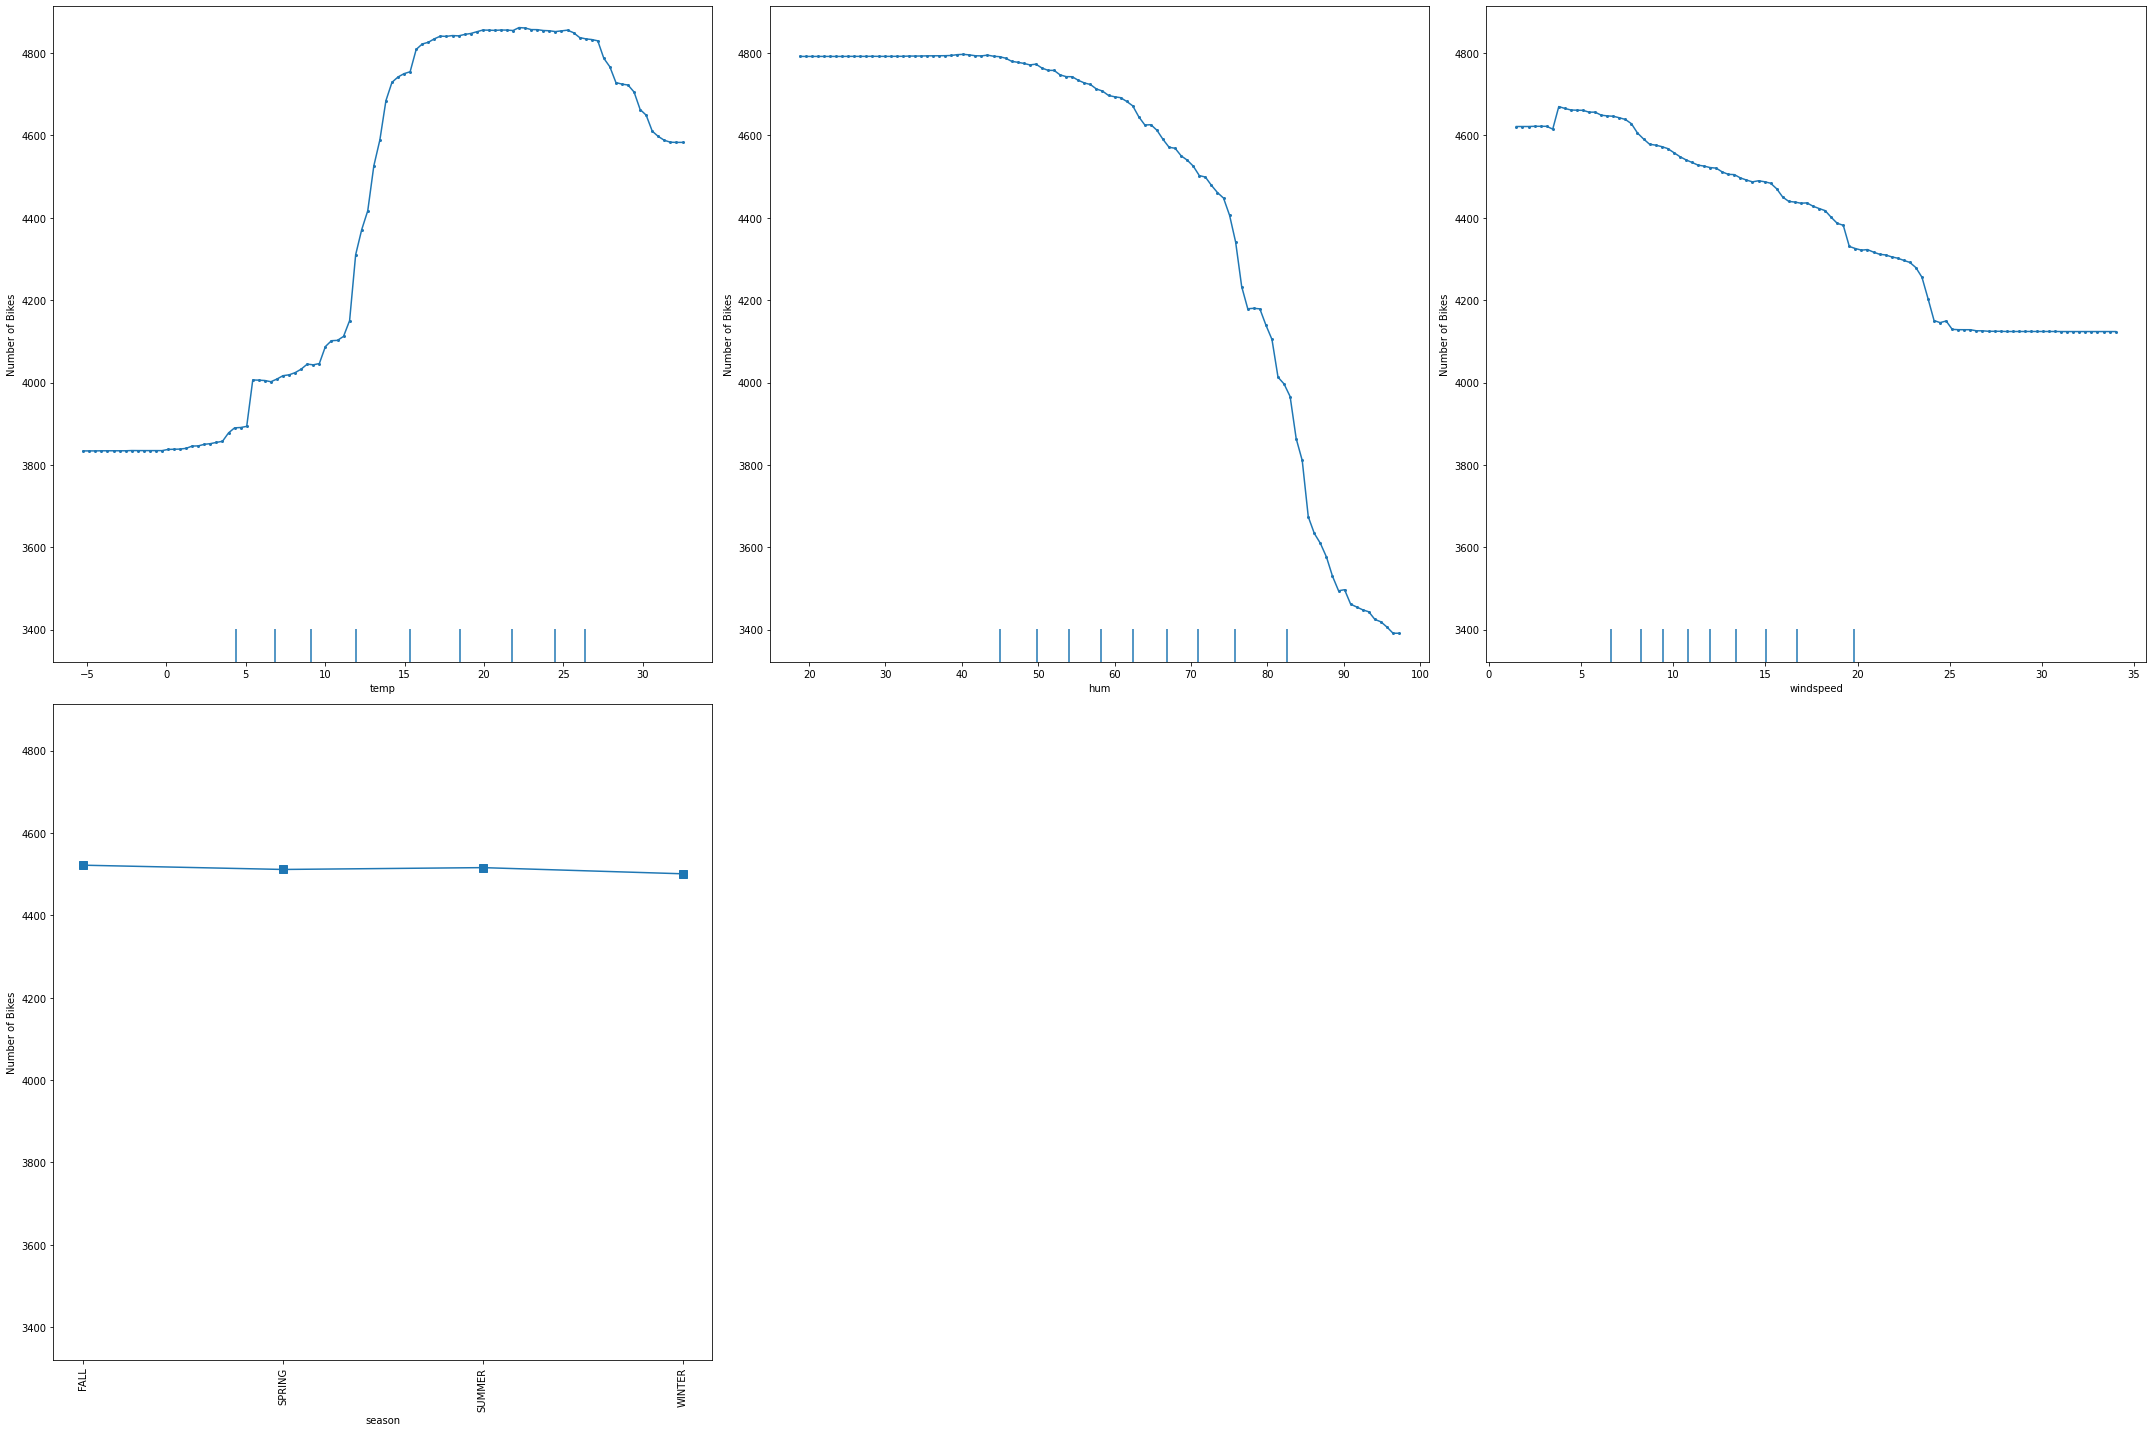

In [12]:
plot_pd(exp=exp, fig_kw={'figheight':20, 'figwidth':30})

In [13]:
feature_interaction = [(feature_names.index('temp'), feature_names.index('windspeed')),
                       (feature_names.index('mnth'), feature_names.index('weather'))]

In [14]:
exp_int = explainer.explain(X=X_train, features=feature_interaction, kind='average')

array([[<AxesSubplot:xlabel='temp', ylabel='windspeed'>,
        <AxesSubplot:xlabel='weather', ylabel='mnth'>]], dtype=object)

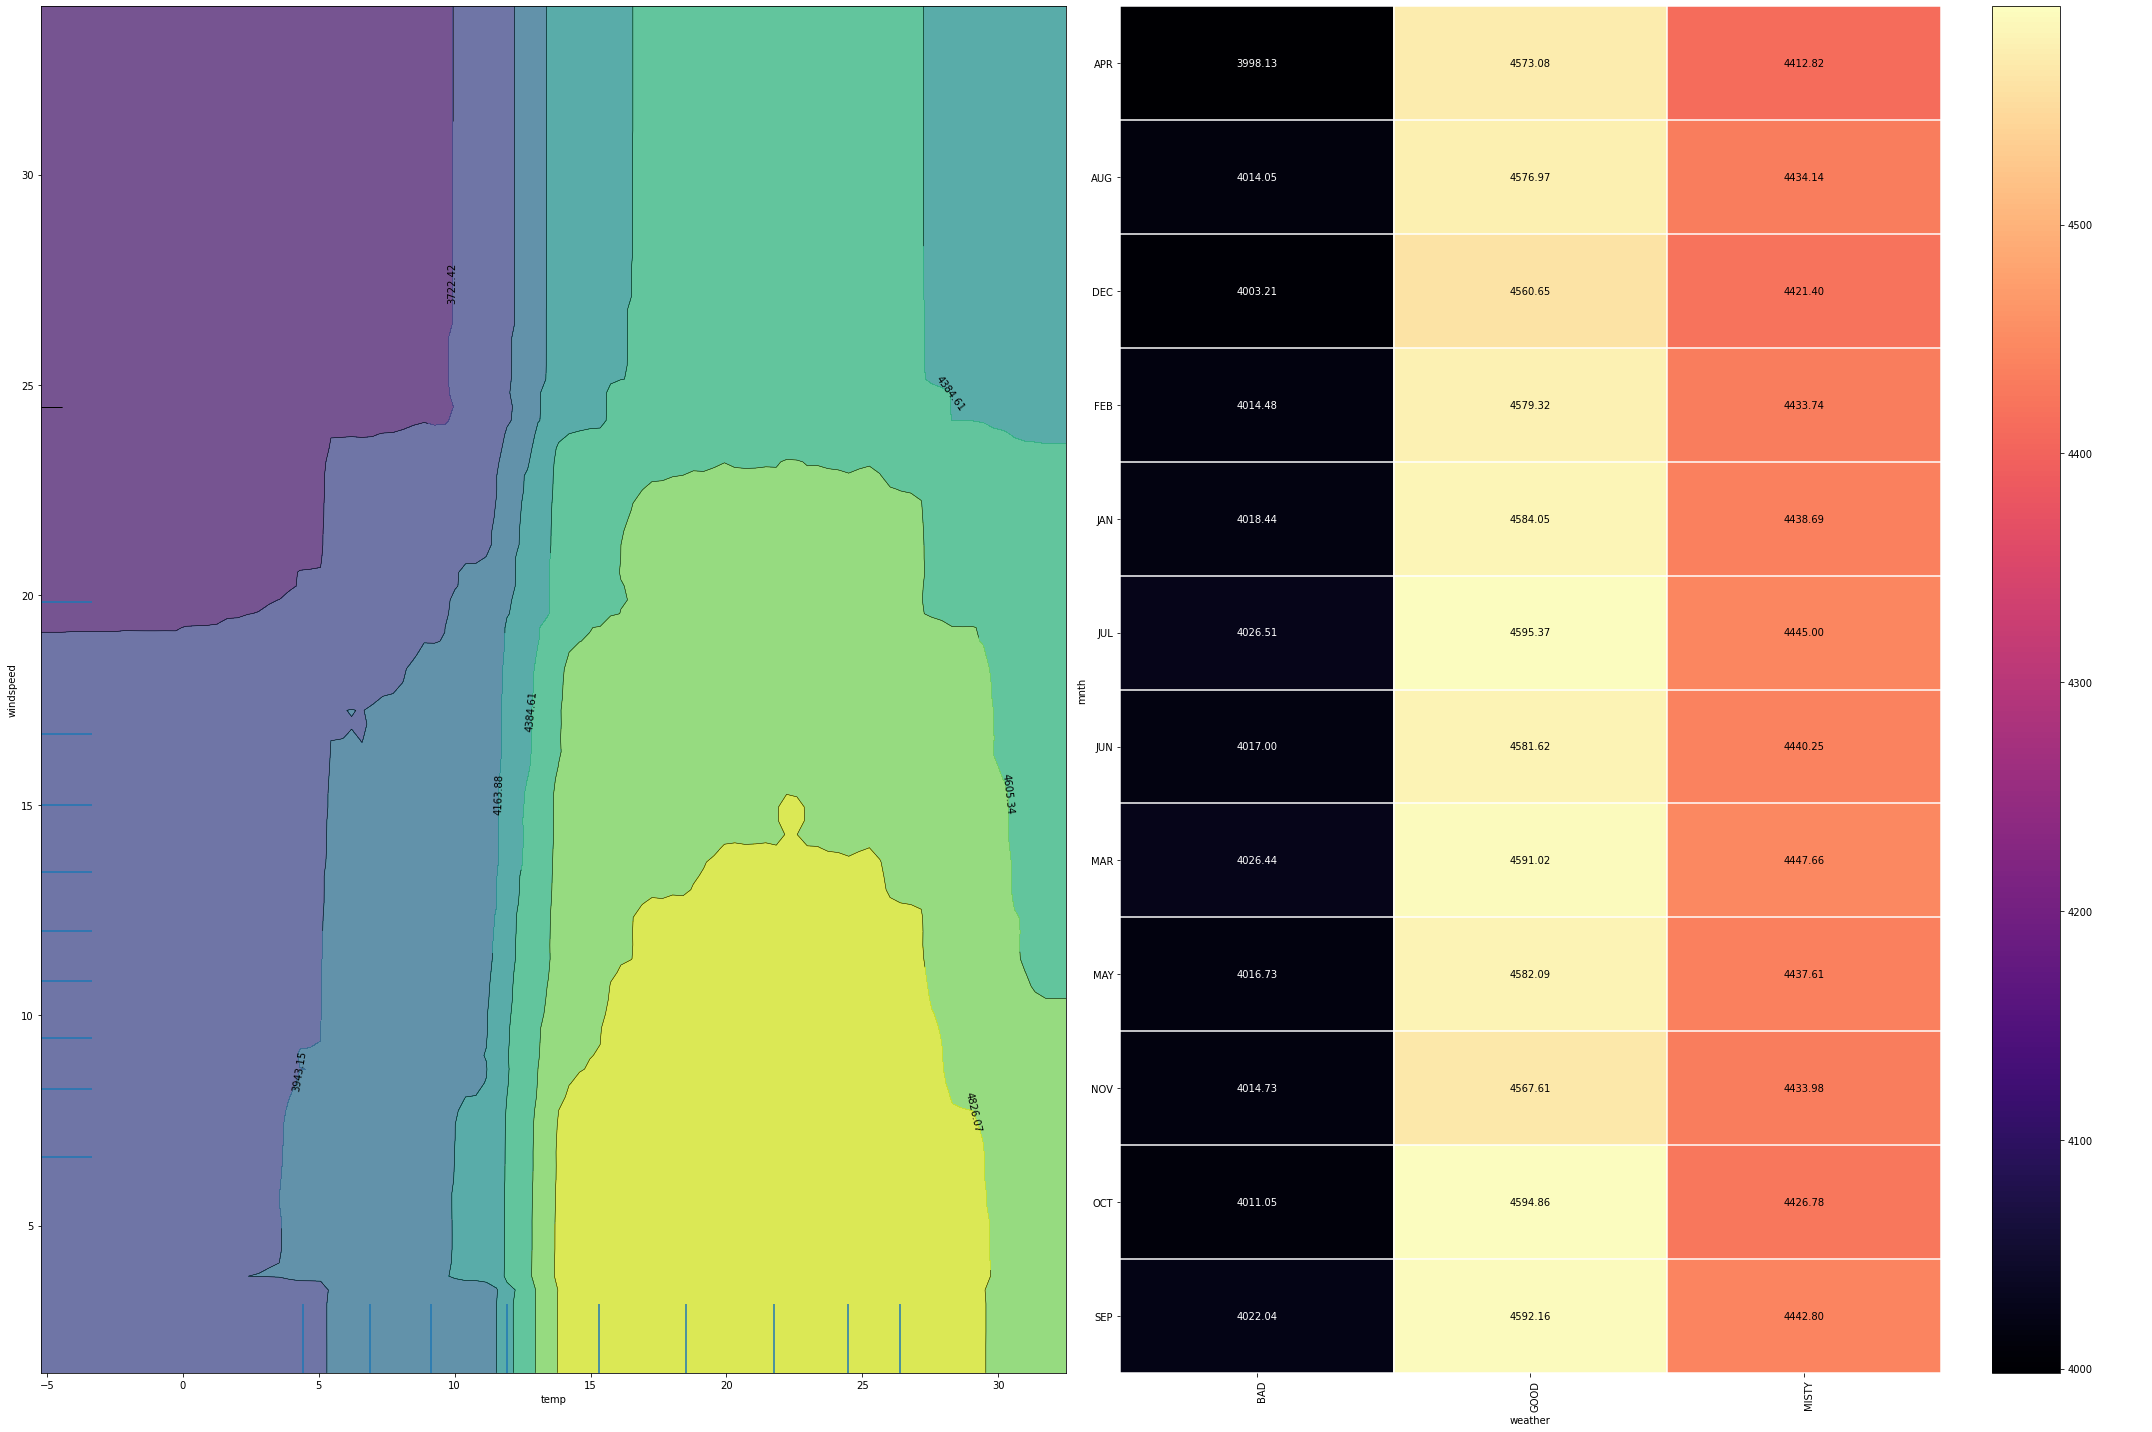

In [15]:
plot_pd(exp=exp_int, fig_kw={'figheight':20, 'figwidth':30})

In [16]:
pd_var = PartialDependenceVariance(predictor=prediction_fn, feature_names=feature_names, categorical_names=categorical_names, target_names=target_names)

In [17]:
exp_importance_all = pd_var.explain(X=X_train, method='importance')
exp_importance_all

Explanation(meta={
  'name': 'PartialDependenceVariance',
  'type': ['blackbox'],
  'explanations': ['global'],
  'params': {
              'percentiles': (0.0, 1.0),
              'grid_resolution': 100,
              'feature_names': ['instant', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'workday', 'weather', 'days_since_2011', 'cnt_2d_bfr'],
              'categorical_names': {
                                     1: ['FALL', 'SPRING', 'SUMMER', 'WINTER'],
                                     2: [2011, 2012],
                                     3: ['APR', 'AUG', 'DEC', 'FEB', 'JAN', 'JUL', 'JUN', 'MAR', 'MAY', 'NOV', 'OCT', 'SEP'],
                                     4: ['N', 'Y'],
                                     5: ['FRI', 'MON', 'SAT', 'SUN', 'THU', 'TUE', 'WED'],
                                     10: ['N', 'Y'],
                                     11: ['BAD', 'GOOD', 'MISTY']}
                                   ,
              't

array([[<AxesSubplot:title={'center':'Number of Bikes'}, xlabel='Feature importance'>]],
      dtype=object)

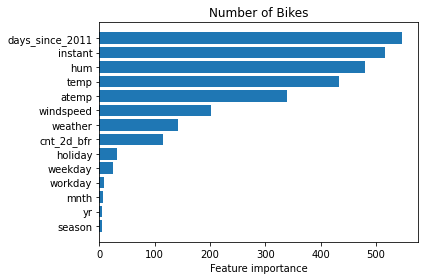

In [18]:
plot_pd_variance(exp=exp_importance_all)

array([[<AxesSubplot:title={'center':'imp(days_since_2011) = 547.663'}, xlabel='days_since_2011', ylabel='Number of Bikes'>,
        <AxesSubplot:title={'center':'imp(instant) = 515.528'}, xlabel='instant', ylabel='Number of Bikes'>,
        <AxesSubplot:title={'center':'imp(hum) = 479.480'}, xlabel='hum', ylabel='Number of Bikes'>],
       [<AxesSubplot:title={'center':'imp(temp) = 432.696'}, xlabel='temp', ylabel='Number of Bikes'>,
        <AxesSubplot:title={'center':'imp(atemp) = 339.385'}, xlabel='atemp', ylabel='Number of Bikes'>,
        <AxesSubplot:title={'center':'imp(windspeed) = 202.574'}, xlabel='windspeed', ylabel='Number of Bikes'>],
       [<AxesSubplot:title={'center':'imp(weather) = 141.522'}, xlabel='weather', ylabel='Number of Bikes'>,
        <AxesSubplot:title={'center':'imp(cnt_2d_bfr) = 115.624'}, xlabel='cnt_2d_bfr', ylabel='Number of Bikes'>,
        <AxesSubplot:title={'center':'imp(holiday) = 31.043'}, xlabel='holiday', ylabel='Number of Bikes'>],
       [<

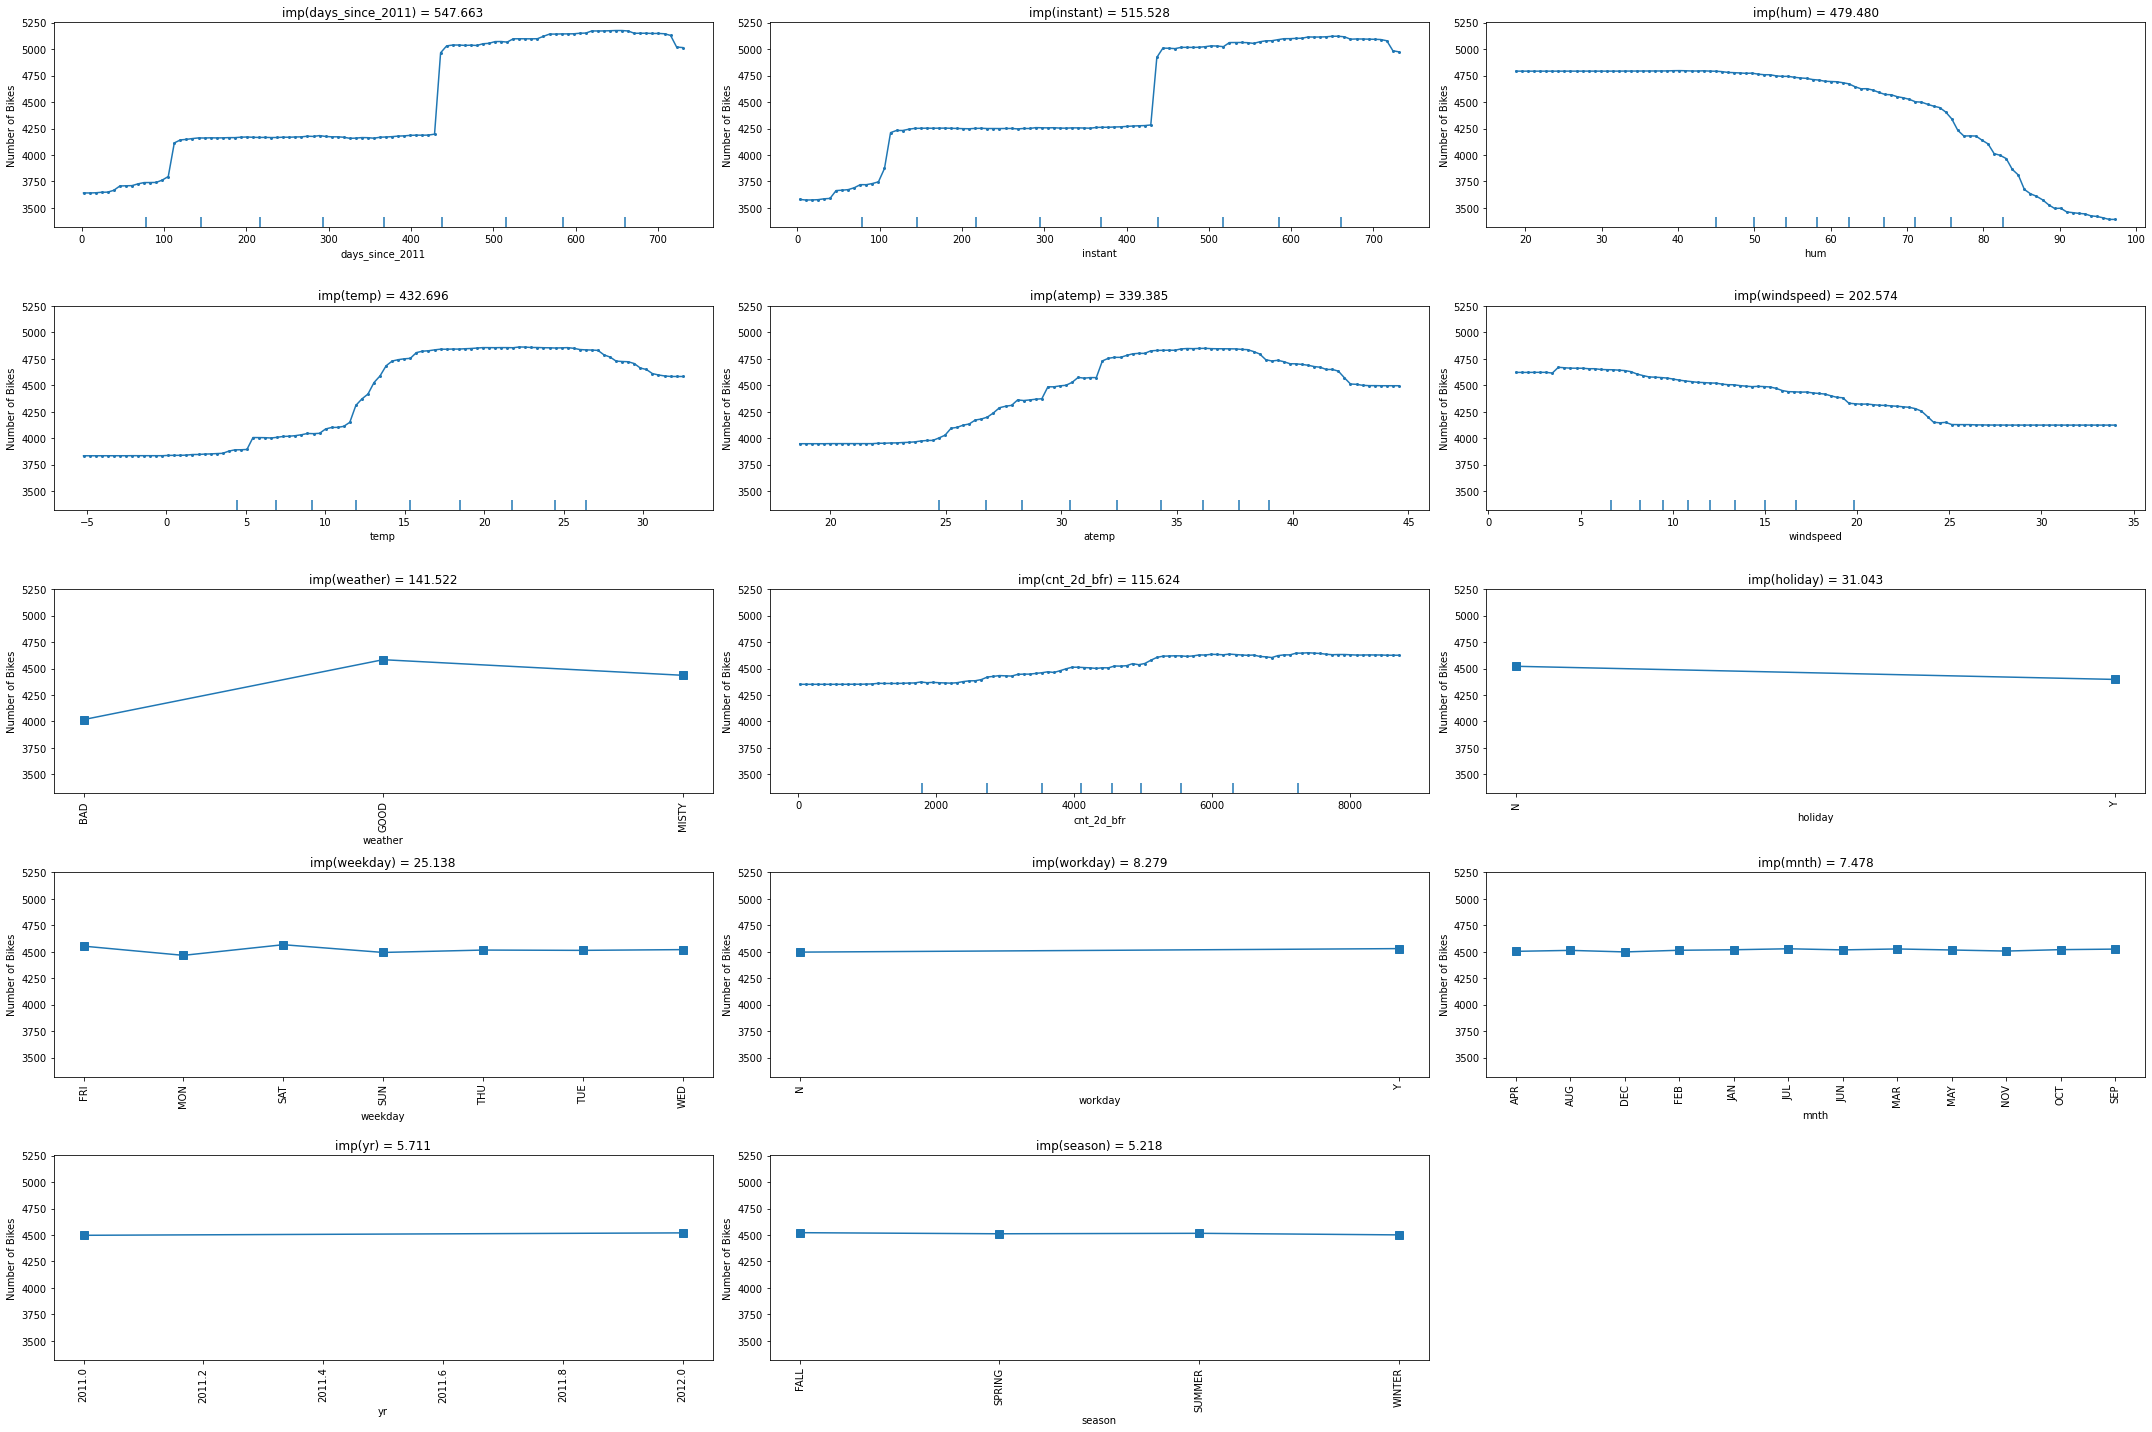

In [19]:
plot_pd_variance(exp=exp_importance_all, summarise=False, fig_kw={'figheight':20, 'figwidth':30})

In [20]:
data = load_iris()
feature_names = data.feature_names
target_names = data.target_names
feature_names, target_names

(['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'],
 array(['setosa', 'versicolor', 'virginica'], dtype='<U10'))

In [21]:
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
accuracy_score(y_test, lr.predict(X_test)), lr.score(X_test, y_test)

(1.0, 1.0)

In [23]:
proba_ale_lr = ALE(lr.predict_proba, feature_names=feature_names, target_names=target_names)
logit_ale_lr = ALE(lr.decision_function, feature_names=feature_names, target_names=target_names)

In [24]:
proba_exp_lr = proba_ale_lr.explain(X_train)
logit_exp_lr = logit_ale_lr.explain(X_test)
proba_ale_lr, logit_ale_lr

(ALE(meta={
   'name': 'ALE',
   'type': ['blackbox'],
   'explanations': ['global'],
   'params': {
               'check_feature_resolution': True,
               'low_resolution_threshold': 10,
               'extrapolate_constant': True,
               'extrapolate_constant_perc': 10.0,
               'extrapolate_constant_min': 0.1,
               'min_bin_points': 4}
             ,
   'version': '0.9.6'}
 ),
 ALE(meta={
   'name': 'ALE',
   'type': ['blackbox'],
   'explanations': ['global'],
   'params': {
               'check_feature_resolution': True,
               'low_resolution_threshold': 10,
               'extrapolate_constant': True,
               'extrapolate_constant_perc': 10.0,
               'extrapolate_constant_min': 0.1,
               'min_bin_points': 4}
             ,
   'version': '0.9.6'}
 ))

array([[<AxesSubplot:xlabel='petal length (cm)', ylabel='ALE'>]],
      dtype=object)

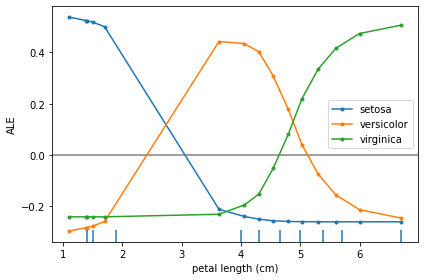

In [25]:
plot_ale(proba_exp_lr, features=[2])

array([[<AxesSubplot:xlabel='petal length (cm)', ylabel='ALE'>]],
      dtype=object)

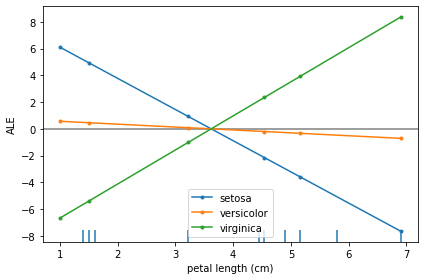

In [26]:
plot_ale(logit_exp_lr, features=[2])

array([[<AxesSubplot:xlabel='petal length (cm)', ylabel='ALE'>]],
      dtype=object)

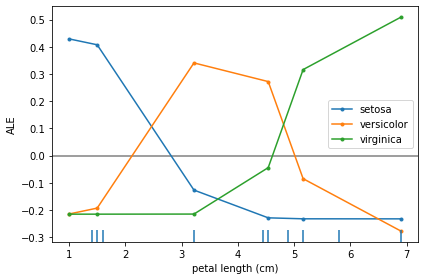

In [27]:
plot_ale(proba_ale_lr.explain(X_test), features=[2])

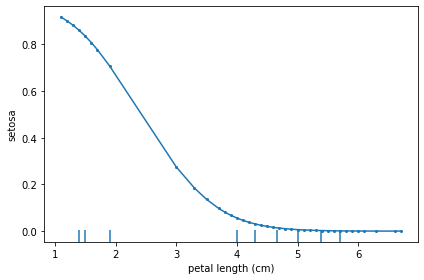

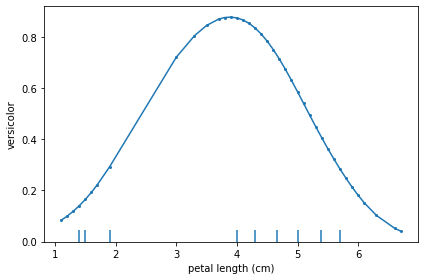

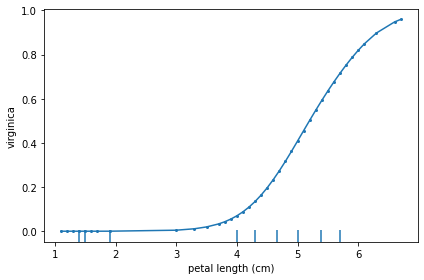

In [28]:
explainer_pd = PartialDependence(predictor=lr.predict_proba, feature_names=feature_names, target_names=target_names)
exp_pd = explainer_pd.explain(X=X_train, kind='average')
for i in range(3):
    plot_pd(exp=exp_pd, target=i, features=[2])

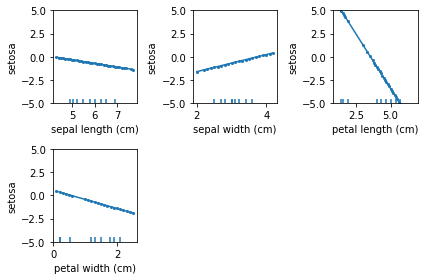

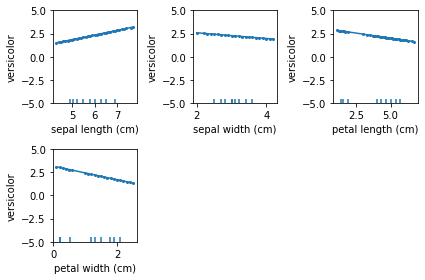

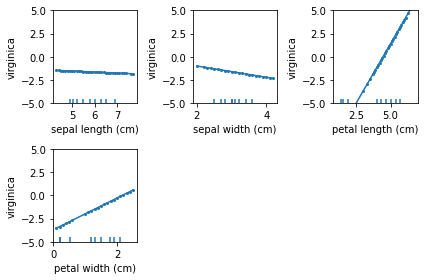

In [29]:
explainer_pd2 = PartialDependence(predictor=lr.decision_function, feature_names=feature_names, target_names=target_names)
exp_pd = explainer_pd2.explain(X=X_train, kind='average')
for i in range(3):
    plot_pd(exp=exp_pd, target=i, pd_limits=[-5, 5])

In [30]:
pd_var = PartialDependenceVariance(predictor=lr.predict_proba, feature_names=feature_names, target_names=target_names)
exp_importance = pd_var.explain(X=X_train, method='importance')

array([[<AxesSubplot:title={'center':'setosa'}, xlabel='Feature importance'>,
        <AxesSubplot:title={'center':'versicolor'}, xlabel='Feature importance'>,
        <AxesSubplot:title={'center':'virginica'}, xlabel='Feature importance'>]],
      dtype=object)

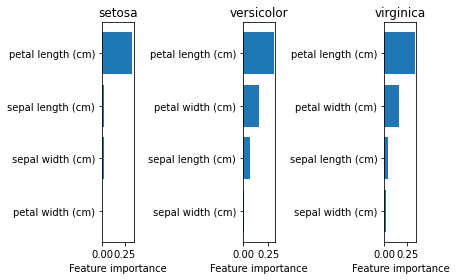

In [31]:
plot_pd_variance(exp=exp_importance, targets=[0, 1, 2])

In [32]:
gb = XGBClassifier()
gb.fit(X_train, y_train)
accuracy_score(y_test, gb.predict(X_test)), gb.score(X_test, y_test)

(1.0, 1.0)

In [33]:
proba_ale_gb = ALE(predictor=gb.predict_proba, feature_names=feature_names, target_names=target_names)
proba_exp_gb = proba_ale_gb.explain(X=X_train)

array([[<AxesSubplot:xlabel='sepal length (cm)', ylabel='ALE'>,
        <AxesSubplot:xlabel='sepal width (cm)', ylabel='ALE'>],
       [<AxesSubplot:xlabel='petal length (cm)', ylabel='ALE'>,
        <AxesSubplot:xlabel='petal width (cm)', ylabel='ALE'>]],
      dtype=object)

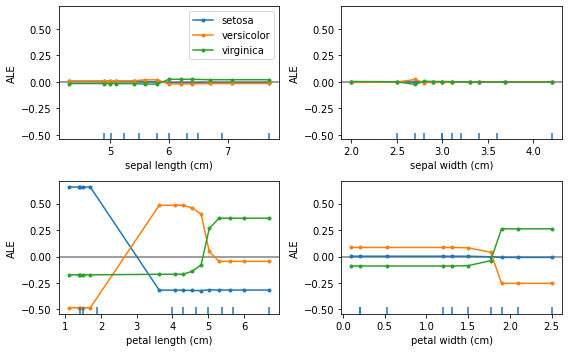

In [34]:
plot_ale(proba_exp_gb, n_cols=2, fig_kw={'figheight':5, 'figwidth':8})

In [35]:
gb.feature_importances_

array([0.0112614 , 0.02780121, 0.7450407 , 0.21589662], dtype=float32)

array([[<AxesSubplot:xlabel='petal length (cm)', ylabel='ALE'>,
        <AxesSubplot:xlabel='petal width (cm)', ylabel='ALE'>]],
      dtype=object)

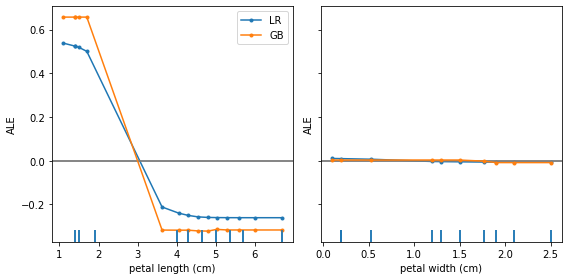

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='row')
plot_ale(proba_exp_lr, features=[2, 3], targets=['setosa'], ax=ax, line_kw={'label':'LR'})
plot_ale(proba_exp_gb, features=[2, 3], targets=['setosa'], ax=ax, line_kw={'label':'GB'})

In [37]:
proba_pd_gb = PartialDependence(predictor=gb.predict_proba, feature_names=feature_names, target_names=target_names)
proba_exp_pd_gb = proba_pd_gb.explain(X=X_train)

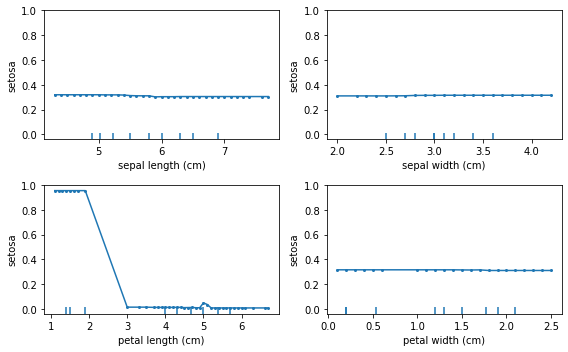

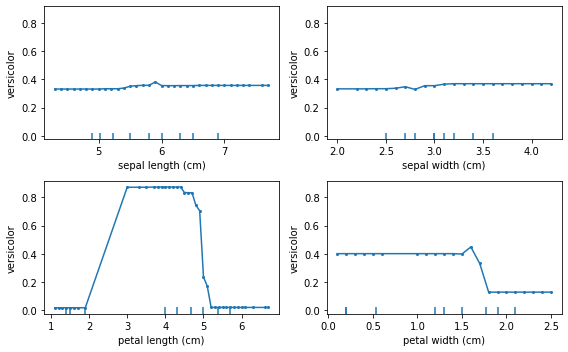

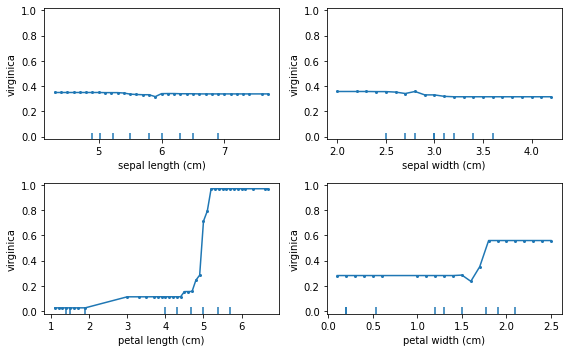

In [38]:
for i in range(3):
    plot_pd(proba_exp_pd_gb, n_cols=2, target=i, fig_kw={'figheight':5, 'figwidth':8})

In [39]:
pdgb_var = PartialDependenceVariance(predictor=gb.predict_proba, feature_names=feature_names, target_names=target_names)
exp_gb_importance = pdgb_var.explain(X=X_train, method='importance')

array([[<AxesSubplot:title={'center':'setosa'}, xlabel='Feature importance'>,
        <AxesSubplot:title={'center':'versicolor'}, xlabel='Feature importance'>,
        <AxesSubplot:title={'center':'virginica'}, xlabel='Feature importance'>]],
      dtype=object)

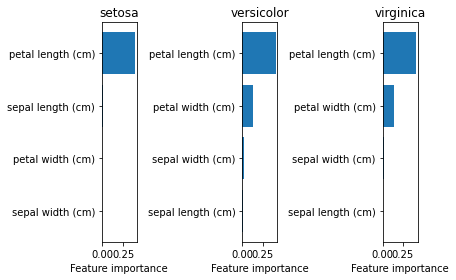

In [40]:
plot_pd_variance(exp=exp_gb_importance, targets=[0, 1, 2])

In [44]:
p = Path.cwd() / 'Backdata'

In [45]:
df = pd.read_csv(p / 'HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [47]:
target_name = 'left'
feature_names = df.columns.to_list()
feature_names.remove(target_name)
categorical_names = ['Work_accident', 'promotion_last_5years', 'sales', 'salary']
numerical_names = [ft for ft in feature_names if ft not in categorical_names]
categorical_indices = [feature_names.index(ft) for ft in categorical_names]

In [48]:
target_perc = df[target_name].value_counts(normalize=True).mul(100).rename('percent').reset_index()
target_perc

,left,percent
0,0,76.191746
1,1,23.808254


In [49]:
X = df[feature_names].to_numpy()
y = df[target_name].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [50]:
preprocessor = ColumnTransformer([('cat', OneHotEncoder(sparse_output=True, drop='if_binary', handle_unknown='ignore'),
                                   categorical_indices)], remainder='passthrough')

In [51]:
preprocessor = preprocessor.fit(X_train)
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

In [52]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
rf = rf.fit(X_train_ohe, y_train)
y_train_hat = rf.predict(X_train_ohe)
print(classification_report(y_train, y_train_hat))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9142
           1       1.00      1.00      1.00      2857

    accuracy                           1.00     11999
   macro avg       1.00      1.00      1.00     11999
weighted avg       1.00      1.00      1.00     11999



In [53]:
y_test_hat = rf.predict(X_test_ohe)
print(classification_report(y_test, y_test_hat))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2286
           1       1.00      0.97      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [62]:
def predict_fn(X: np.ndarray) -> np.ndarray:
    return rf.predict(preprocessor.transform(X))

In [63]:
explainer = PermutationImportance(predictor=predict_fn, score_fns=['accuracy', 'f1'], feature_names=feature_names, verbose=True)
exp = explainer.explain(X=X_test, y=y_test)

100%|██████████| 9/9 [00:20<00:00,  2.25s/it]


array([[<AxesSubplot:title={'center':'accuracy'}, xlabel='Permutation feature importance'>,
        <AxesSubplot:title={'center':'f1'}, xlabel='Permutation feature importance'>]],
      dtype=object)

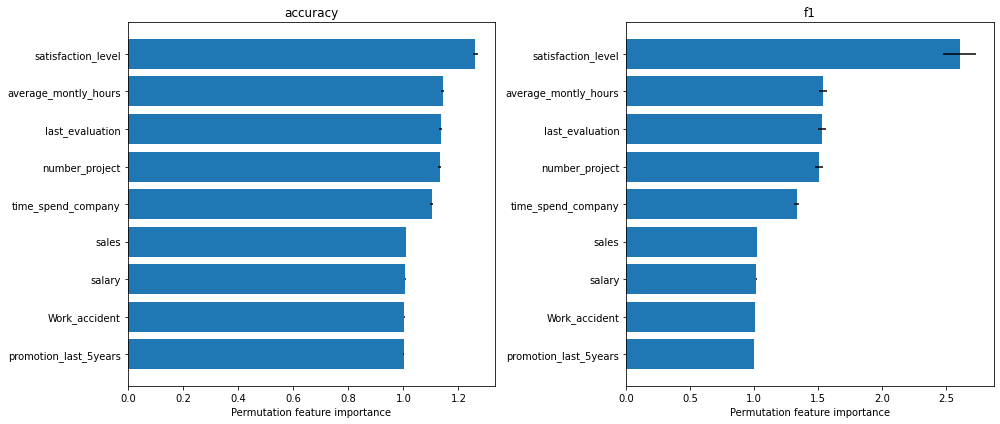

In [66]:
plot_permutation_importance(exp, n_cols=2, fig_kw={'figheight':6, 'figwidth':14})